In [23]:
import pandas as pd
from sklearn.cluster import KMeans, SpectralClustering, Birch, HDBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import f1_score, accuracy_score,r2_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split
from collections import Counter


In [24]:
# Define clustering models in a dictionary for flexibility
clustering_models = {
    "KMeans": lambda n: KMeans(n_clusters=n, random_state=0),
    "Spectral": lambda n: SpectralClustering(n_clusters=n, assign_labels='discretize', random_state=0, affinity='nearest_neighbors'),
    "Birch": lambda n: Birch(n_clusters=n)
}

# Initialize result container
metrics = []
metric_kmeans = []
latents = []

for n_latents in [3, 5]:
    data = pd.read_csv(f"../data/fmri_derived/dfcs/latent_representations_{n_latents}.csv", index_col=0)
    
    for n_clusters in [5, 8]:  
        for name, model_func in clustering_models.items():
            model = model_func(n_clusters)
            labels = model.fit_predict(data)
    
            # Evaluation with distance metrics
            ss = silhouette_score(data, labels)
            db = davies_bouldin_score(data, labels)
            ch = calinski_harabasz_score(data, labels)
    
            if name == "KMeans":
                metric_kmeans.append([n_latents, n_clusters, model.inertia_])

            # Evaluation with a classifier
            y = labels
            X = data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            model = LGBMClassifier(n_estimators=100, verbose=-1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro')
            model = LGBMRegressor(verbose=-1)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
 
    
            # Store results
            metrics.append([name, n_latents, n_clusters, ss, db, ch, acc, f1,r2])
            latents.append(pd.Series(name = f"{name}_{n_latents}_{n_clusters}", data =labels))

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics, columns=["Model", "n_latents", "n_clusters", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz", "Accuracy","f1", "r2"])
df_metrics

,Model,n_latents,n_clusters,Silhouette,Davies-Bouldin,Calinski-Harabasz,Accuracy,f1,r2
0,KMeans,3,5,0.521450,0.541942,25077.428978,0.996293,0.996540,0.992259
1,Spectral,3,5,0.507749,0.542813,21098.609234,0.996293,0.996955,0.991856
2,Birch,3,5,0.428136,0.517361,15949.391899,0.996293,0.995669,0.984752
3,KMeans,3,8,0.508142,0.534959,35757.850170,0.989805,0.990755,0.967307
4,Spectral,3,8,0.496457,0.522649,31598.237906,0.988879,0.987675,0.974777
5,Birch,3,8,0.462370,0.524363,22390.669503,0.994439,0.991123,0.993147
6,KMeans,5,5,0.511861,0.567346,24179.467213,0.996756,0.996709,0.988221
7,Spectral,5,5,0.512252,0.550976,22890.176228,0.996293,0.995683,0.991505
8,Birch,5,5,0.462618,0.511127,14023.975499,0.994439,0.986689,0.988301
9,KMeans,5,8,0.502057,0.556617,34233.828772,0.988415,0.986017,0.973915


In [11]:
Y = pd.DataFrame(latents).T
#Y.to_csv("../data/fmri_derived/dfcs/all_dfcs_flattened_clusters.csv")

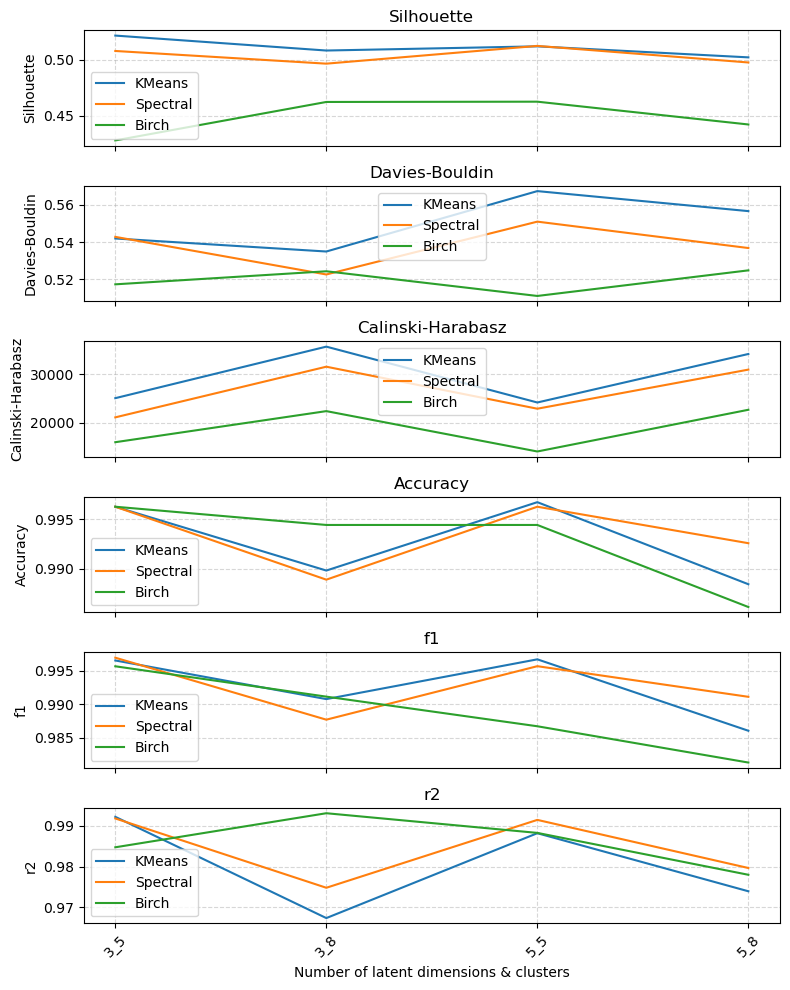

In [12]:
df_metrics['parameters'] = df_metrics.apply(lambda row: f"{row['n_latents']}_{row['n_clusters']}", axis=1)
metrics = ["Silhouette", "Davies-Bouldin", "Calinski-Harabasz","Accuracy","f1", "r2"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, 10), sharex=True)
for i, metric in enumerate(metrics):
    ax = axes[i]
    for model in ["KMeans", "Spectral", "Birch"]:
        dummy = df_metrics[df_metrics["Model"] == model][['parameters', metric]].set_index('parameters')
        ax.plot(dummy, label=model)
    
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='x', rotation=45)

axes[-1].set_xlabel("Number of latent dimensions & clusters")

plt.tight_layout()
plt.show()
#plt.savefig("../data/fmri_derived/dfcs/Clusters_Evaluation.png", dpi=100)
#plt.close()


In [ ]:
# Columns you want to filter on
cols = ["Silhouette", "Davies-Bouldin", "Calinski-Harabasz"]

# Compute 75th percentile threshold for each column
thresholds = df_metrics[cols].quantile(0.7)

# Keep rows where ALL three columns are >= their respective thresholds
df_filtered = df_metrics[
    (df_metrics[cols[0]] >= thresholds[cols[0]]) &
    (df_metrics[cols[1]] <= thresholds[cols[1]]) &
    (df_metrics[cols[2]] >= thresholds[cols[2]])
]
df_filtered